In [1]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm

In [2]:
# Read in AMF catalog
amf = pd.read_csv('dr9_main_complete.csv', header=None)
amf.columns = ['amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id']

c = SkyCoord(amf['amf_ra'],amf['amf_dec'],frame='icrs',unit='deg')
amf['glat'] = c.galactic.b.degree
amf['glon'] = c.galactic.l.degree

amf_whl_red = amf[(amf.whl_id!='-9999') & (amf.red_id!='-9999')]

In [3]:
hdul = fits.open("../overlaps/masks/DR5_cluster-catalog_v1.1.fits")
data = hdul[1].data

adv = pd.DataFrame({'name':data['name'].byteswap().newbyteorder(),
                    'RA':data['RADeg'].byteswap().newbyteorder(),
                    'dec':data['decDeg'].byteswap().newbyteorder(),
                    'SNR':data['SNR'].byteswap().newbyteorder(),
                    'redshift':data['redshift'].byteswap().newbyteorder(),
                    'RM':data['RM'].byteswap().newbyteorder()})

c = SkyCoord(adv['RA'],adv['dec'],frame='icrs',unit='deg')
adv['glat'] = c.galactic.b.degree
adv['glon'] = c.galactic.l.degree

In [4]:
arw_not_adv = pd.DataFrame()
arw_not_adv = pd.DataFrame(data=arw_not_adv, columns=amf_whl_red.columns)

In [5]:
arw_not_adv = arw_not_adv.iloc[0:0]

for i in tqdm(range(amf_whl_red.shape[0])):
    matches = adv.loc[(adv['glat'].sub(amf_whl_red.iloc[i]['glat']).abs()<1) & (adv['glon'].sub(amf_whl_red.iloc[i]['glon']).abs()<1)]
    if len(matches)==0:     
        arw_not_adv.loc[len(arw_not_adv)] = amf_whl_red.iloc[i]
        
arw_not_adv = arw_not_adv.reset_index()
print(len(arw_not_adv))
print(len(arw_not_adv[arw_not_adv.amf_rh>50]))

100%|██████████| 15064/15064 [01:52<00:00, 133.53it/s]

10099
1286


---

In [6]:
actmap = enmap.read_map("act_dr5.01_s08s18_AA_f220_daynight_map.fits")

In [7]:
# actmap_hp = reproject.healpix_from_enmap(actmap[0],nside=2048,lmax=6000)
# cmb = hp.read_map("COM_CMB_IQU-smica_2048_R3.00_full.fits")
# actmap_not_cmb = actmap_hp-cmb

# hp.mollview(actmap_hp,norm='hist',title='Masked S/N map')

In [8]:
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [9]:
# eshow(comptony, **{'downgrade': 4, 'ticks': 4, 'colorbar': True})
# eshow(comptony, **{"sub": "0:5 ,-180:-160", 'ticks': 4, "downgrade": 4, "colorbar": True})

In [24]:
stamps90 = []

# ras  = arw_not_adv['amf_ra']
# decs = arw_not_adv['amf_dec']
ras  = arw_not_adv[arw_not_adv.amf_rh>50]['amf_ra']
decs = arw_not_adv[arw_not_adv.amf_rh>50]['amf_dec']-1

N = len(ras)
# N=200
stack_CMB_kSZ           = 0
stack_CMB_kSZ_deproject = 0
c = 0

for i in tqdm(range(N)):
    stamp = reproject.thumbnails(actmap,coords = np.deg2rad([decs[i], ras[i]]),r=utils.arcmin)
#     stamp_1arc = reproject.thumbnails(actmap,coords = np.deg2rad([decs[i], ras[i]]),r=5*utils.arcmin)
    
    if stamp is None:
        continue
    elif stamp[0][0][0]==0.0:
        continue
        
    stamps90.append(sum(sum(stamp[0])))
    
    stack_CMB_kSZ += stamp 
    c += 1
#     plt.imshow(stamp[0])
#     plt.title(arw_not_adv.iloc[i]['red_id'], fontsize = 16)
#     plt.savefig('ex{}.png'.format(i))
#     plt.show()
    
# Normalize the stamps
stack_CMB_kSZ /= c
stack_CMB_kSZ_deproject /= c

100%|██████████| 1286/1286 [00:19<00:00, 64.66it/s]


In [25]:
np.average(stamps90)

-183.48077262393556

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


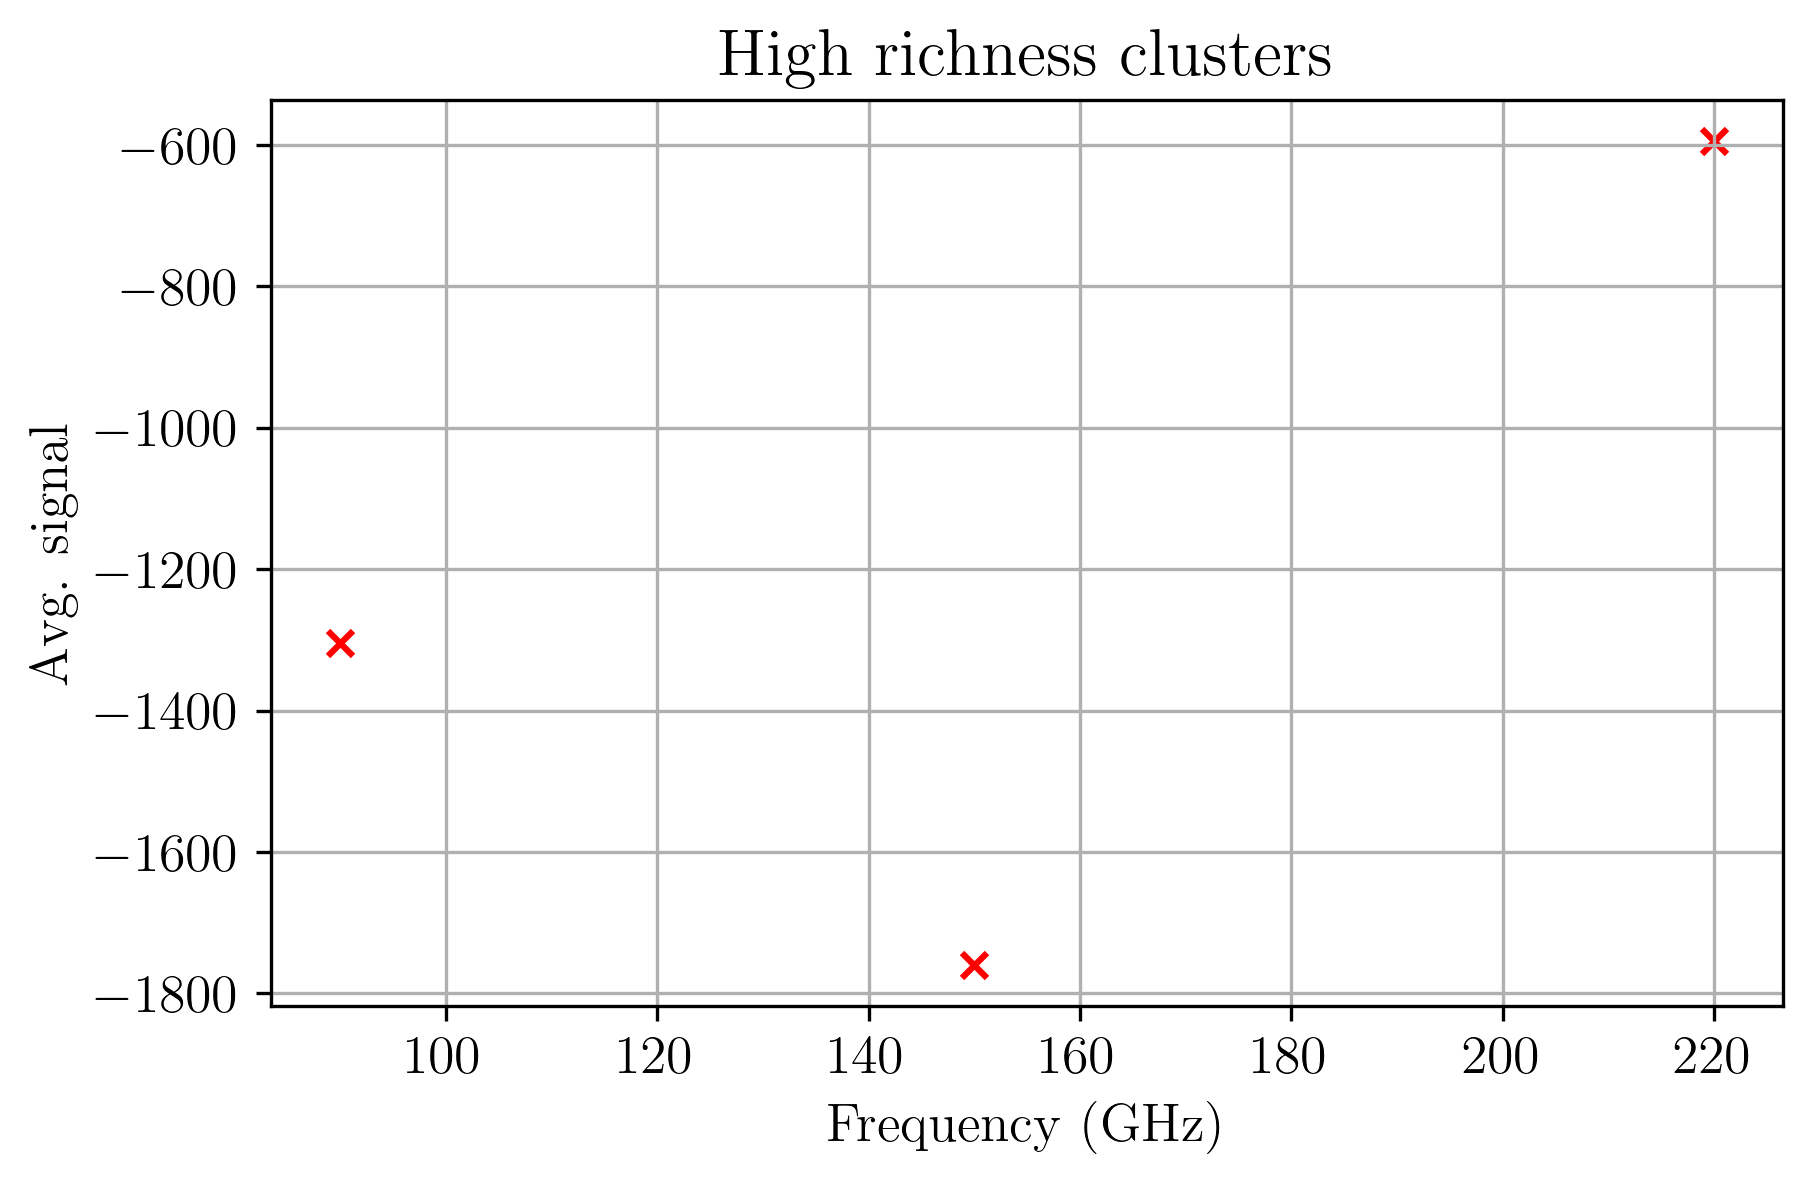

In [16]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

freq = [90,150,220]
full = [-710,-610,615]
highrh = [-1305,-1760,-595]
plt.scatter(freq,highrh,marker='x',c='r')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Avg. signal")
plt.title("High richness clusters",size=16)
plt.grid()
plt.savefig('highrh.png')

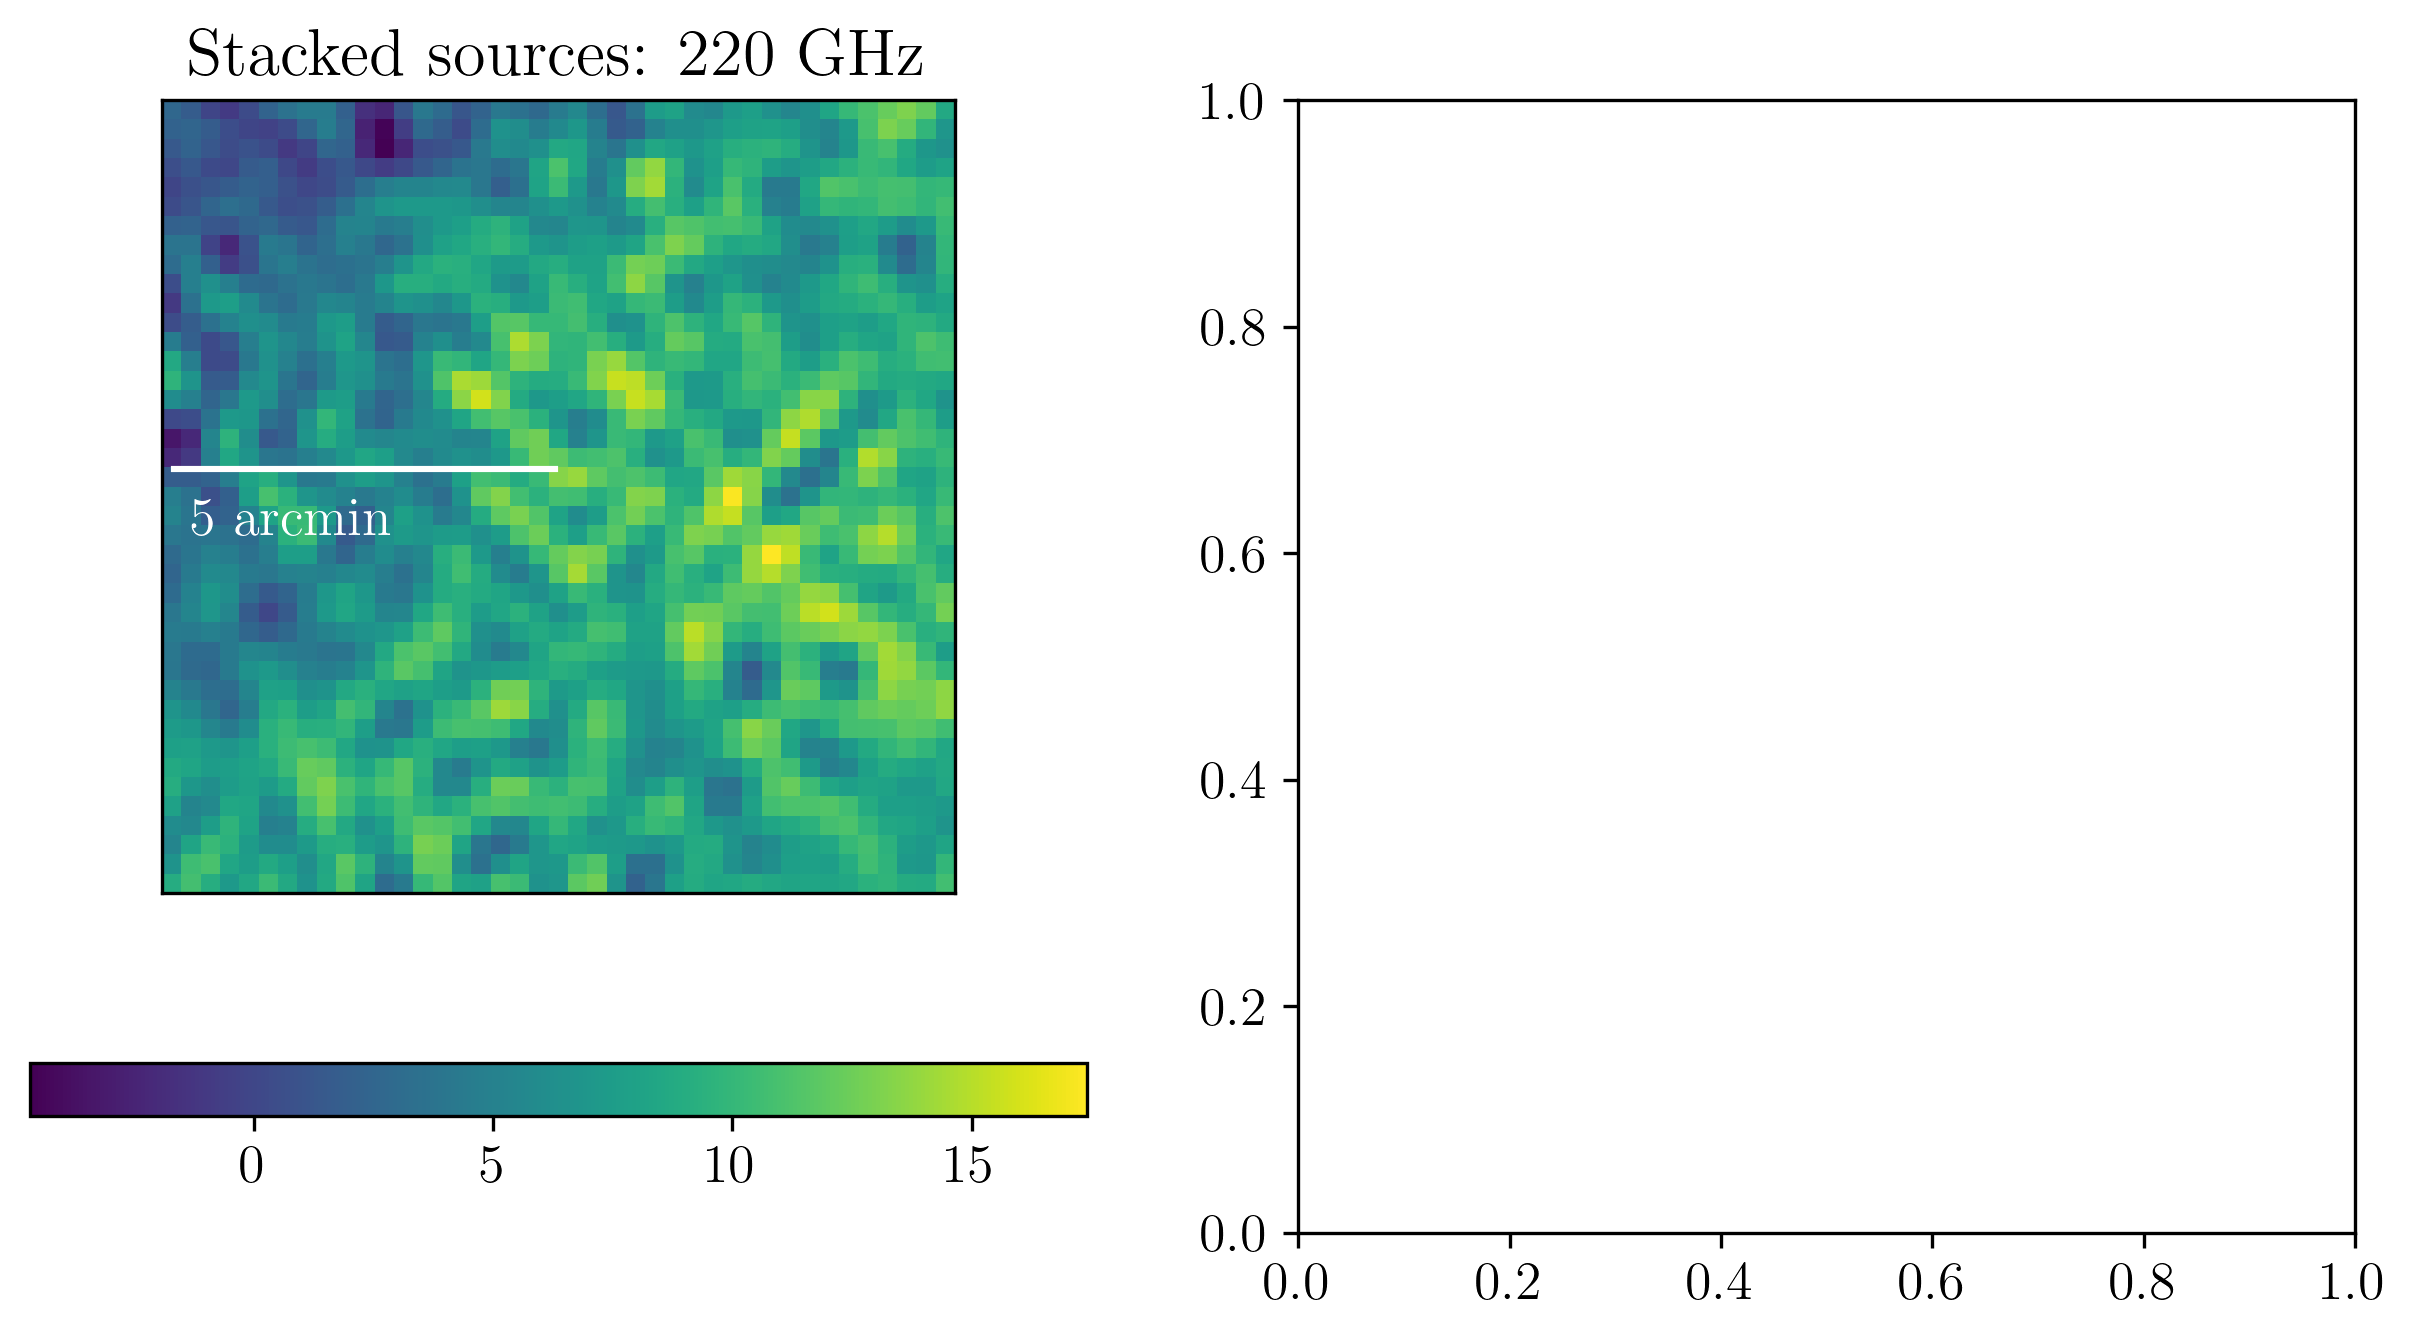

<Figure size 975x600 with 0 Axes>

In [17]:
# Now we can plot both of these and compare
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

f, ax = plt.subplots(1,2, figsize=(10, 5))

f1 = ax[0].imshow(stack_CMB_kSZ[0])
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

scalebar = AnchoredSizeBar(ax[0].transData,
                           19.8, '', 'center left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=0.1)

ax[0].add_artist(scalebar)
ax[0].text(1,22,"5 arcmin",color='white')
ax[0].set_title("Stacked sources: 220 GHz", fontsize = 16)
plt.colorbar(mappable = f1, ax = ax[0],orientation='horizontal')

plt.show()
plt.savefig("90.png")

---